<a href="https://colab.research.google.com/github/taliarosenkranz/TranSecure/blob/main/Fraud_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt



In [ ]:
import pandas as pd
import psycopg2
from sqlalchemy import create_engine

# Database connection parameters
dbname = 'transactions'
user = 'postgres'
password = 'root'
host = 'localhost'
port = '5433'
conn = psycopg2.connect(dbname=dbname, user=user, password=password, host=host, port=port)


# Create the database connection
#engine = create_engine(f'postgresql://{user}:{password}@{host}:{port}/{dbname}')

# Load data into DataFrame
query = "SELECT price, status FROM transecure"
df = pd.read_sql(query, conn)

# Display the first few rows of the DataFrame
print(df.head())


In [4]:
_df = pd.read_excel("orders.xlsx")

In [5]:
df = _df.copy()

Preprocessing

In [6]:
df.head()

,order_id,order_date,order_status,price,avs_mismatch,customer_account_age,order_source,billing_zip,shipping_name_length,classification_score,customer_id
0,621481,2023-06-11T00:00:00Z,approved,540,True,287,phone,41123,19,0.371480,372
1,788013,2022-10-30T00:00:00Z,approved,680,True,81,phone,71879,6,0.867578,860
2,743724,2023-06-19T00:00:00Z,chargeback,260,False,286,web,65701,20,0.630769,971
3,709340,2021-02-28T00:00:00Z,approved,720,False,320,mobile app,63666,18,0.431331,913
4,816507,2021-05-13T00:00:00Z,approved,990,True,31,phone,86613,8,0.276696,905


In [7]:
df.isnull().sum()

order_id                0
order_date              0
order_status            0
price                   0
avs_mismatch            0
customer_account_age    0
order_source            0
billing_zip             0
shipping_name_length    0
classification_score    0
customer_id             0
dtype: int64

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40825 entries, 0 to 40824
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   order_id              40825 non-null  int64  
 1   order_date            40825 non-null  object 
 2   order_status          40825 non-null  object 
 3   price                 40825 non-null  int64  
 4   avs_mismatch          40825 non-null  bool   
 5   customer_account_age  40825 non-null  int64  
 6   order_source          40825 non-null  object 
 7   billing_zip           40825 non-null  int64  
 8   shipping_name_length  40825 non-null  int64  
 9   classification_score  40825 non-null  float64
 10  customer_id           40825 non-null  int64  
dtypes: bool(1), float64(1), int64(6), object(3)
memory usage: 3.2+ MB


The dataset contains a score which classifies each transaction as more or less likely to be charged back. In order to label the dataset properly, a threshold will be set on the classification score and based on that, each transaction will be labeled as accepted or declined. With these labels, a machine learning model will be trained to predict weheather or not a transaction should be accepted or declined. With such a prediction, the company will be able to limit the chargeback amounts they are paying to their clients.



In [10]:
# calculating 90th percentile of score
threshold = np.percentile(df.classification_score, 90)
print(threshold)

0.9520177251845594


In [ ]:
print(f'Based on the data provided, 90% of the orders will be approved if the classification score is at {round(threshold, 3)} or below. Any order with a score above this threshold will be understood as fraud and therefore declined.')

Based on the data provided, 90% of the orders will be approved if the classification score is at 0.952 or below. Any order with a score above this threshold will be understood as fraud and therefore declined.


In [11]:
#adding status of approval column based on threshold to df
df['status'] = df['classification_score'].apply(lambda x: 'Declined' if x > threshold else 'Approved')

In [12]:
#creating json from data for postres DB
json_data = df.to_json(orient='records')
# Write to a JSON file
with open('your_file.json', 'w') as json_file:
    json_file.write(json_data)

print("CSV to JSON conversion completed!")

CSV to JSON conversion completed!


In [13]:
distribution = df.status.value_counts()
distribution

status
Approved    36742
Declined     4083
Name: count, dtype: int64

In [15]:
# Plot the distribution of status
ax = df.plot(kind='bar', x='status', legend=False)

# Set the title and labels
plt.title("Distribution of Status")
plt.ylabel("Order count")
plt.xticks(rotation=0)

# Annotate each bar with the value on top
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

# Show the plot
plt.show()

KeyboardInterrupt: 

Error in callback <function _draw_all_if_interactive at 0x7e8b58f38820> (for post_execute):


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7e8b58f27a30> (for post_execute):


KeyboardInterrupt: 

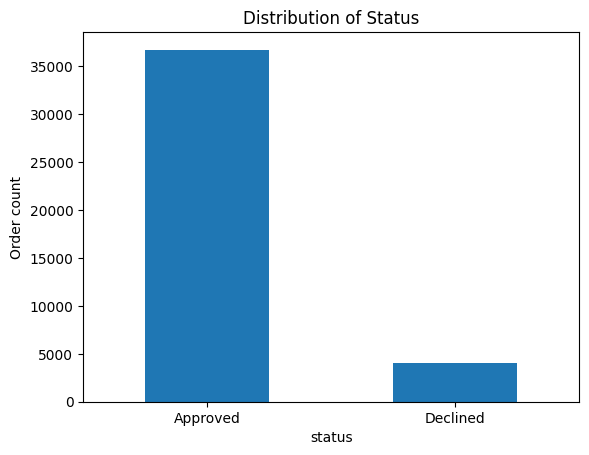

In [ ]:
#visualizing the distribution between approved and denied orders based on set threshold
distribution.plot(kind = "bar")
plt.title("Distribution of Status")
plt.ylabel("Order count")
plt.xticks(rotation=0)
plt.show()

Plotting model score distribution

In [ ]:
#density plot of classification score marking threshold
sns.kdeplot(data=df, x="classification_score", fill=True)
plt.title('Density Plot of Classification Score')
plt.xlabel('Classification Score')
plt.ylabel('Density')

plt.axvline(x=threshold, color='red', linestyle='--', label='Threshold at 0.95')
plt.legend()
plt.show()

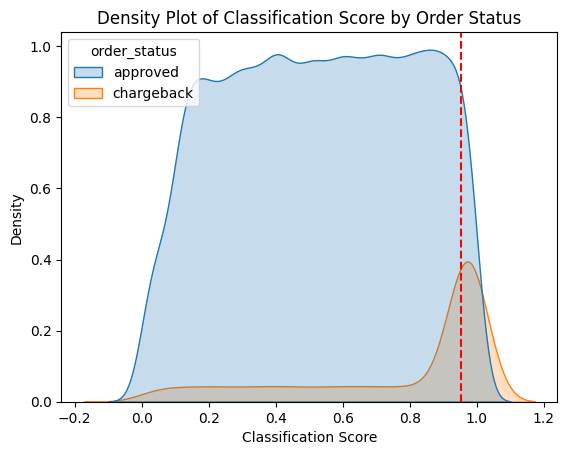

In [ ]:
#density plot of classification score showing chargeback
sns.kdeplot(data=df, x="classification_score", hue="order_status", fill=True)
plt.title('Density Plot of Classification Score by Order Status')
plt.xlabel('Classification Score')
plt.ylabel('Density')
plt.axvline(x=threshold, color='red', linestyle='--', label='Threshold at 0.95')
plt.show()

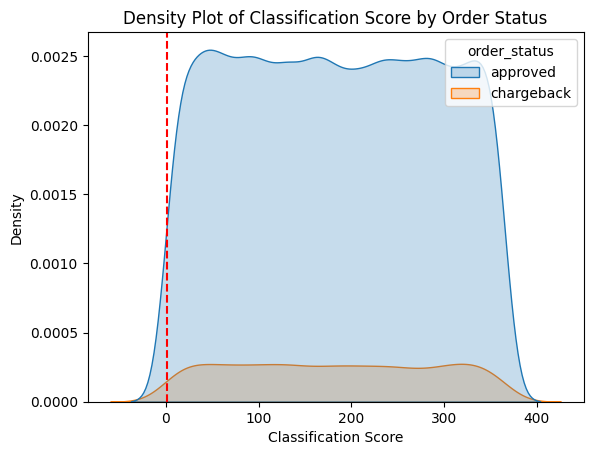

In [16]:
#density plot of classification score showing chargeback
sns.kdeplot(data=df, x="customer_account_age", hue="order_status", fill=True)
plt.title('Density Plot of Classification Score by Order Status')
plt.xlabel('Classification Score')
plt.ylabel('Density')
plt.axvline(x=threshold, color='red', linestyle='--', label='Threshold at 0.95')
plt.show()

Customer account age to chargeback proportion

In [17]:
df.customer_account_age.min()

1

In [18]:
df.customer_account_age.max()

365

In [20]:
#creating bins to split up age groups
df['account_age_group'] = pd.cut(df['customer_account_age'], bins=7, labels=['1', '2', '3', '4', '5', '6', '7'])

In [24]:
account_age_proportion = df.groupby("account_age_group")['order_status'].value_counts().unstack()
account_age_proportion

order_status,approved,chargeback
account_age_group,,
1,5418,619
2,5304,576
3,5198,569
4,5229,555
5,5197,547
6,5231,529
7,5260,593


In [23]:
#calculating chargeback ratio
account_age_proportion = account_age_proportion['chargeback'] / (account_age_proportion['approved'] + account_age_proportion['chargeback'])*100
print(account_age_proportion)

account_age_group
1    10.253437
2     9.795918
3     9.866482
4     9.595436
5     9.522981
6     9.184028
7    10.131556
dtype: float64


Splitting the customer account age into 7 bins and calculating the chb rate to all orders, shows that the youngest account group and oldest account group pose the highest risk in this contilation.

 Machine Learning

In [ ]:
df.columns

Index(['order_id', 'order_date', 'order_status', 'price', 'avs_mismatch',
       'customer_account_age', 'order_source', 'billing_zip',
       'shipping_name_length', 'classification_score', 'customer_id',
       'status'],
      dtype='object')

converting data types suitable for ML training

In [ ]:
# Convert 'order_date' to datetime
df['order_date'] = pd.to_datetime(df['order_date'])


# Extract features from 'order_date'
df['order_year'] = df['order_date'].dt.year
df['order_month'] = df['order_date'].dt.month
df['order_day'] = df['order_date'].dt.day
df['order_dayofweek'] = df['order_date'].dt.dayofweek

df['order_date'] = df['order_date'].dt.date
# Drop the original 'order_date' column
df = df.drop(columns=['order_date'])

In [ ]:
# Encode 'order_status' as numeric categories
df['order_status'] = df['order_status'].astype('category').cat.codes

# Encode 'order_source' as numeric categories
df['order_source'] = df['order_source'].astype('category').cat.codes

# Encode 'status' as numeric categories
df['status'] = df['status'].astype('category').cat.codes

# Now, all columns should be numeric or boolean
print(df.dtypes)

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Correlation Heatmap')
plt.show()

- strong positive correlation between price and order_source_phone indicating orders placed via phone tend to have higher prices compared to other sources.
- slight positive correlation between price and order_status_chargeback meaning there is a slight tendency for those orders to become chargebacks.
- positive correlation between avs mismatch and classification score



In [ ]:
filtered_df = df[df['classification_score'] < 0.01]

# Group by classification_score and count occurrences of avs_mismatch
result = filtered_df.groupby("avs_mismatch")['classification_score'].count()
result

avs_mismatch
False    152
Name: classification_score, dtype: int64

In [ ]:
#df.to_excel("orders_date.xlsx")

In [ ]:
from sklearn.model_selection import train_test_split
X = df.drop(["classification_score", "customer_id", "order_id", "status", "order_status"], axis = 1)
y = df.classification_score
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
#REGRESSION model training
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


# Create regression models
model = make_pipeline(StandardScaler(), GradientBoostingRegressor())

# Train the model
model.fit(X_train, y_train)

# Predict probabilities
y_pred = model.predict(X_test)
#y_pred = y_pred.clip(0, 1)

#EVALUATION
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R²): {r2}")

Mean Absolute Error (MAE): 0.23695241290939556
Mean Squared Error (MSE): 0.0752689602316636
Root Mean Squared Error (RMSE): 0.27435189124856346
R-squared (R²): 0.08327675693349657


These metrics indicate that the model has an average absolute error of approximately 0.2372, meaning that, on average, the predicted classification scores differ from the actual scores by this amount. The MSE and RMSE values, which penalize larger errors more severely, further reinforce that the model's predictions have a moderate level of deviation from the actual values.

The R-squared value of 0.0825 suggests that the model explains approximately 8.25% of the variance in the target variable. This relatively low R² indicates that there is significant room for improvement in the model's predictive power.

Overall, while the model provides a starting point for predicting classification scores, further refinement and potentially more complex modeling approaches are needed to improve its accuracy and explanatory power.

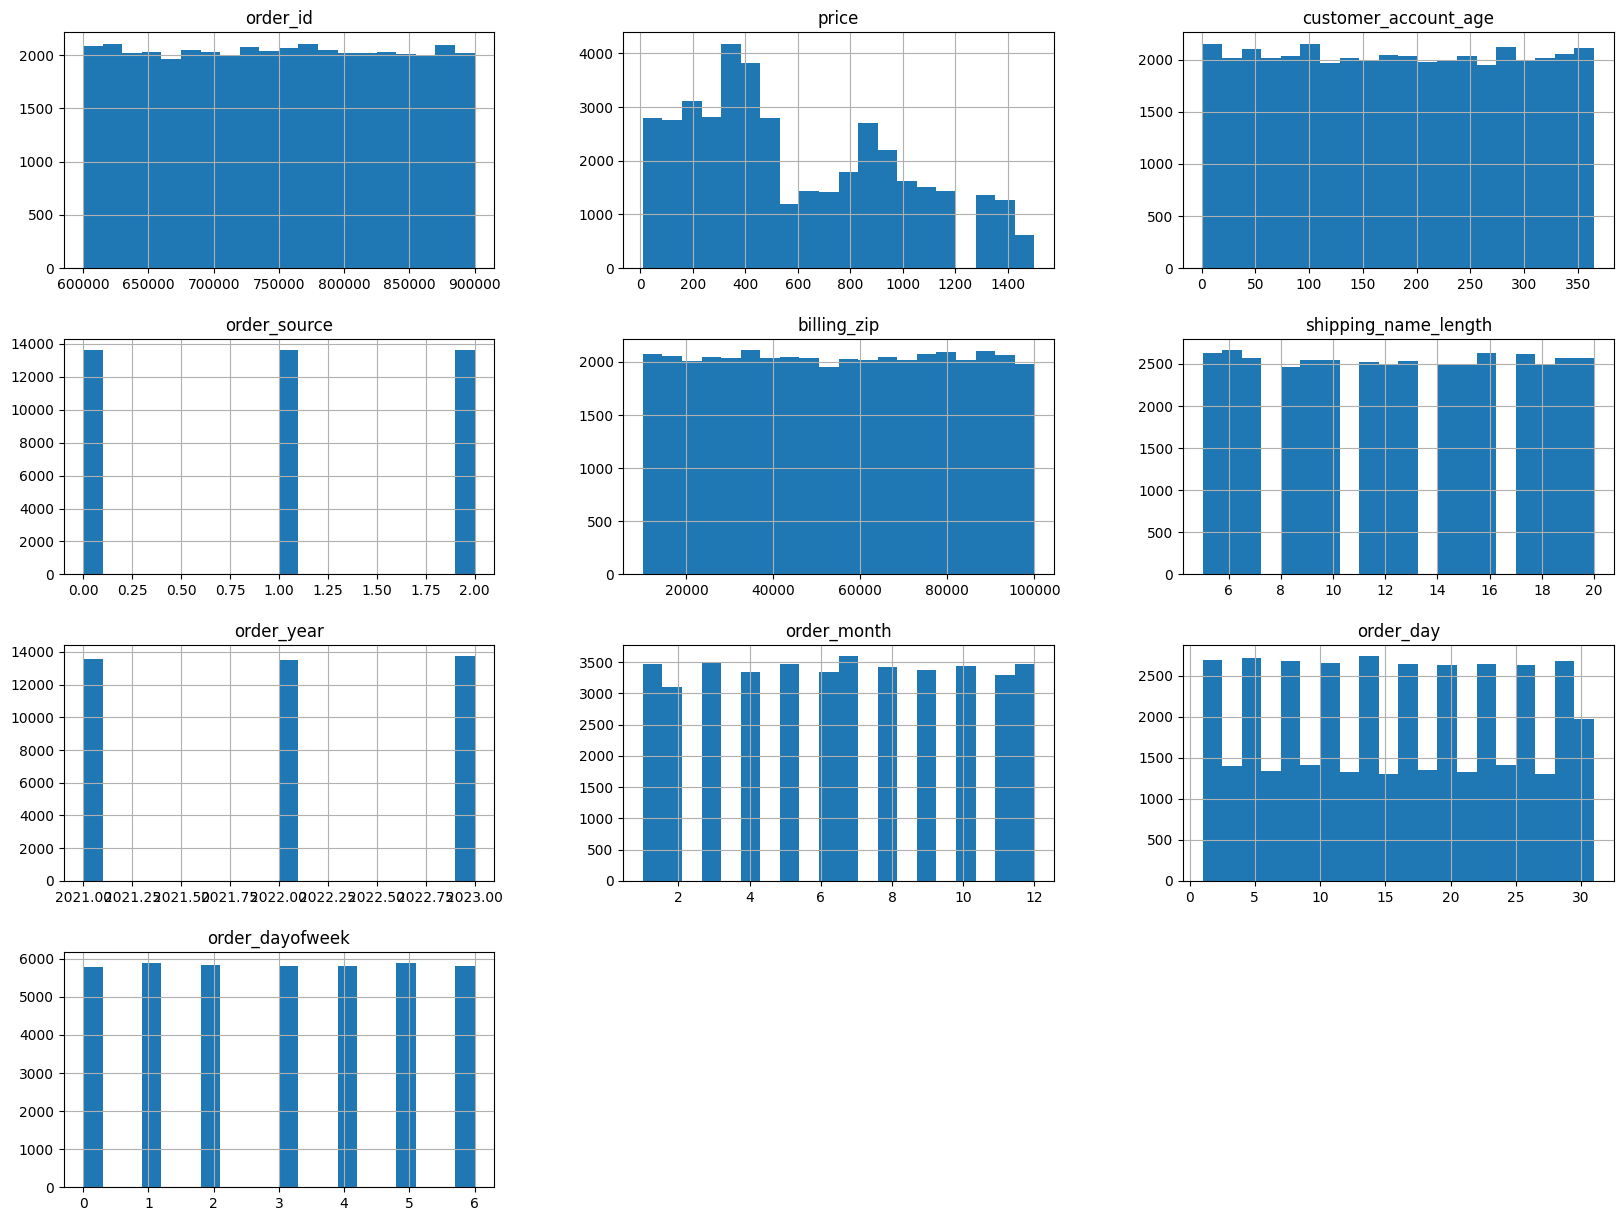

In [ ]:
X.hist(bins=20, figsize=(20, 15))
plt.show()

In [ ]:
# Frequency Encoding for 'billing_zip'
zip_frequency = X['billing_zip'].value_counts().to_dict()
X['billing_zip_freq'] = X['billing_zip'].map(zip_frequency)

# Drop the original 'billing_zip' column
X = X.drop(columns=['billing_zip'])

Summary statistics after normalization:


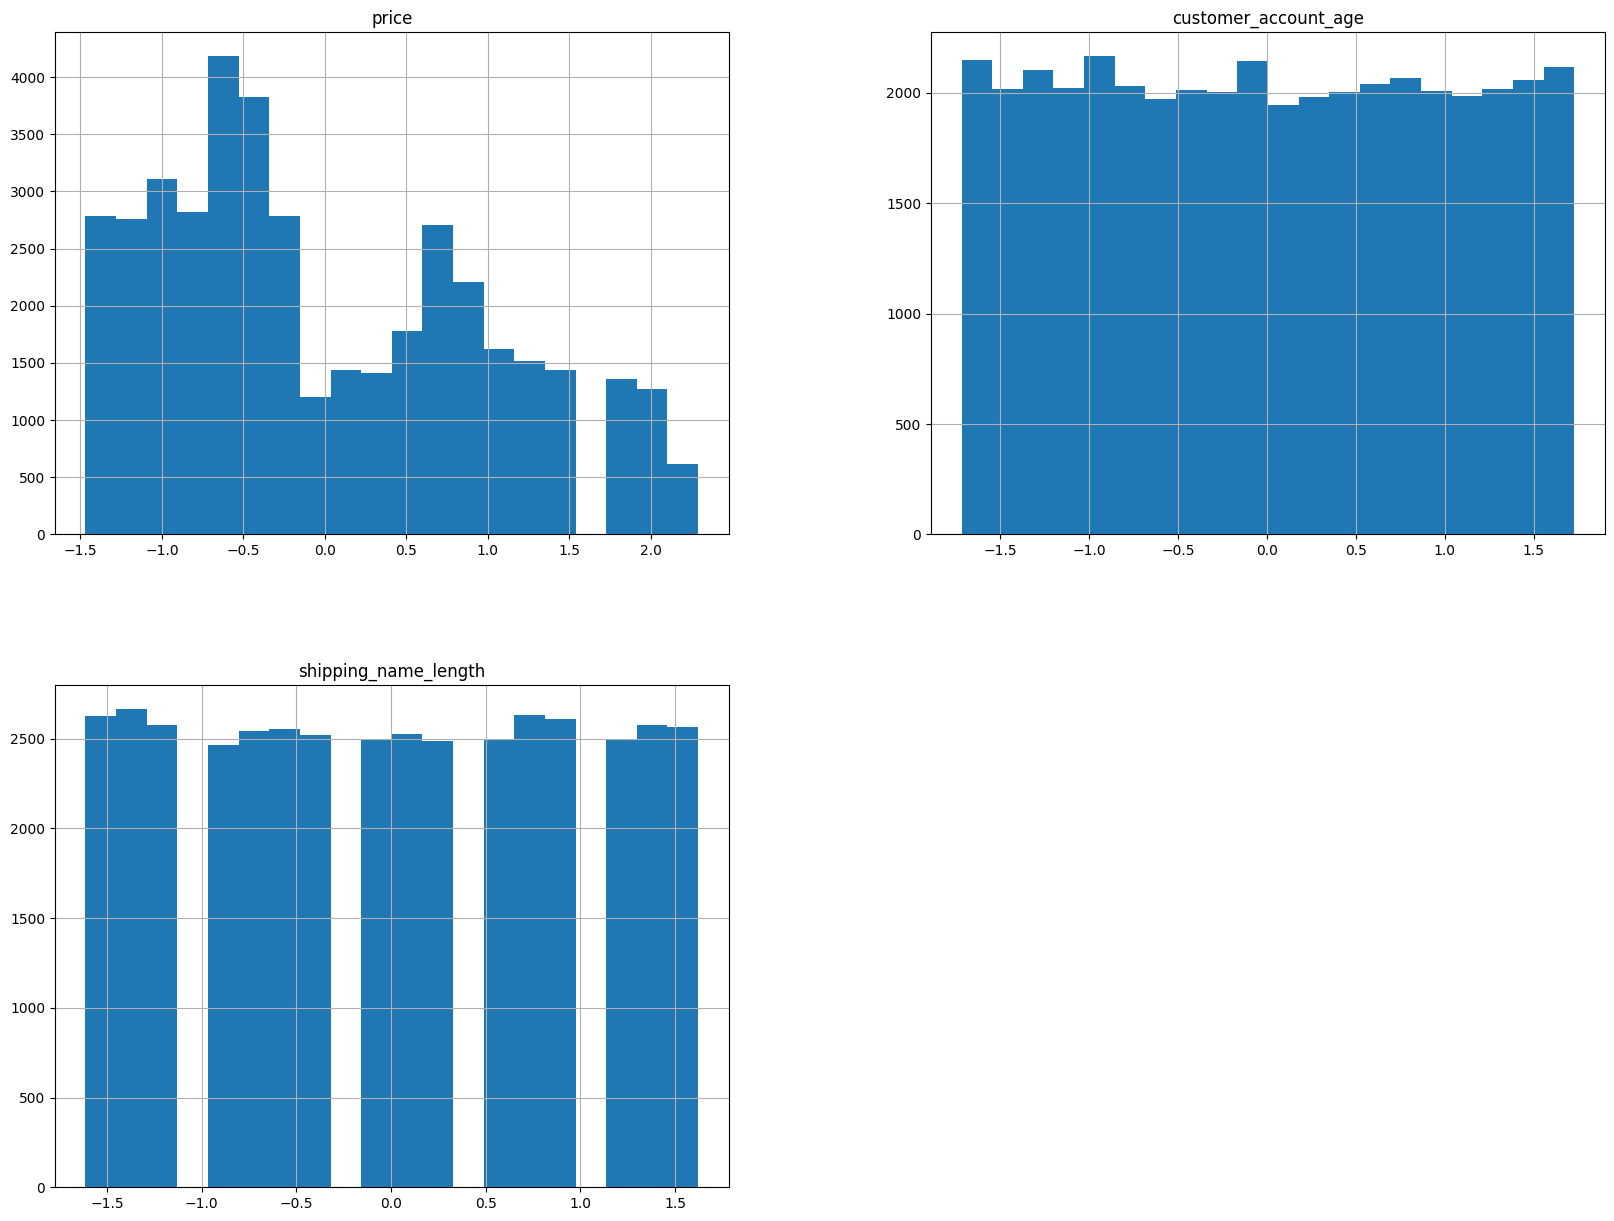

In [ ]:
from sklearn.preprocessing import StandardScaler
# Select columns that likely need normalization
columns_to_normalize = ['price', 'customer_account_age', 'shipping_name_length']

# Initialize StandardScaler
scaler = StandardScaler()

# Normalize the selected columns
X[columns_to_normalize] = scaler.fit_transform(X[columns_to_normalize])

# Check summary statistics after normalization
print("Summary statistics after normalization:")
X[columns_to_normalize].hist(bins=20, figsize=(20, 15))
plt.show()

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to NumPy arrays
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

X['avs_mismatch'] = X['avs_mismatch'].astype(int)

# Ensure all integer columns are int64
int_columns = X.select_dtypes(include=['int8', 'int32', 'int64']).columns
X[int_columns] = X[int_columns].astype('int64')

# Ensure the target column is float64
y = y.astype('float64')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Simplified neural network model
model = Sequential([
    Dense(16, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(16, activation='relu'),
    Dropout(0.5),  # Adding dropout for regularization
    Dense(1, activation='sigmoid')  # Sigmoid activation ensures output is between 0 and 1
])

# Compile the model with a different optimizer and learning rate
optimizer = Adam(learning_rate=0.0001)  # Adjusting the learning rate
model.compile(optimizer=optimizer, loss='mean_squared_error')
# Add EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2,callbacks=[early_stopping])


Epoch 1/50
817/817 [==============================] - 9s 6ms/step - loss: 0.2990 - val_loss: 0.2808
Epoch 2/50
817/817 [==============================] - 3s 4ms/step - loss: 0.2990 - val_loss: 0.2808
Epoch 3/50
817/817 [==============================] - 2s 3ms/step - loss: 0.2982 - val_loss: 0.2808
Epoch 4/50
817/817 [==============================] - 4s 5ms/step - loss: 0.2963 - val_loss: 0.2808
Epoch 5/50
817/817 [==============================] - 2s 3ms/step - loss: 0.2934 - val_loss: 0.2808
Epoch 6/50
817/817 [==============================] - 2s 3ms/step - loss: 0.2917 - val_loss: 0.2808
Epoch 7/50
180/817 [=====>........................] - ETA: 1s - loss: 0.2924

KeyboardInterrupt: 

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Train a linear regression model
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# Predict and evaluate
y_pred_linear = linear_model.predict(X_test)
mse_linear = mean_squared_error(y_test, y_pred_linear)
print(f"Linear Regression MSE: {mse_linear}")



Linear Regression MSE: 0.08814688858042088


In [ ]:
from sklearn.ensemble import RandomForestRegressor

# Calculate sample weights
class_weights = {0: 1.0, 1: 10.0}  # Adjust the weights according to your imbalance
sample_weights = y_train.map(class_weights)

# Create and train a Random Forest Regressor model
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train, sample_weight=sample_weights)

# Predict values
y_pred = model.predict(X_test)

# Ensure predictions are within the valid range if necessary (e.g., 0 and 1 for probabilities)
y_pred = np.clip(y_pred, 0, 1)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R²): {r2}")


Mean Squared Error (MSE): 0.062033239436619717
Mean Absolute Error (MAE): 0.12364727495407227
Root Mean Squared Error (RMSE): 0.24906472941109048
R-squared (R²): 0.31631759465721854


In [ ]:
#simple random forrest but with scaled data (Made no difference)
from sklearn.ensemble import RandomForestRegressor

# Calculate sample weights
class_weights = {0: 1.0, 1: 10.0}  # Adjust the weights according to your imbalance
sample_weights = y_train.map(class_weights)

#scaling data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create and train a Random Forest Regressor model
model = RandomForestRegressor(random_state=42)
model.fit(X_train_scaled, y_train, sample_weight=sample_weights)

# Predict values
y_pred = model.predict(X_test_scaled)

# Ensure predictions are within the valid range if necessary (e.g., 0 and 1 for probabilities)
y_pred = np.clip(y_pred, 0, 1)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R²): {r2}")




Mean Squared Error (MSE): 0.06207951010410288
Mean Absolute Error (MAE): 0.12359093692590324
Root Mean Squared Error (RMSE): 0.24915760093583916
R-squared (R²): 0.31580763513343746


In [ ]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Assuming X and y are your feature matrix and target variable
# Split the data into training and testing sets
X = df.drop(["classification_score", "customer_id", "order_id", "status", "order_status"], axis=1)
y = df['status']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Calculate sample weights
class_weights = {0: 1.0, 1: 10.0}  # Adjust the weights according to your imbalance
sample_weights = y_train.map(class_weights)

# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

# Create the RandomForestRegressor
rf = RandomForestRegressor(random_state=42)

# Perform GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train, sample_weight=sample_weights)

# Get the best estimator
best_rf = grid_search.best_estimator_

# Train the best model on the entire training data
best_rf.fit(X_train, y_train, sample_weight=sample_weights)

# Predict values
y_pred = best_rf.predict(X_test)

# Ensure predictions are within the valid range if necessary (e.g., 0 and 1 for probabilities)
y_pred = np.clip(y_pred, 0, 1)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R²): {r2}")
print(f"Best parameters: {grid_search.best_params_}")


Fitting 3 folds for each of 324 candidates, totalling 972 fits


KeyboardInterrupt: 

In [ ]:
X

,price,avs_mismatch,customer_account_age,order_source,billing_zip,shipping_name_length,order_year,order_month,order_day,order_dayofweek
0,540,True,287,1,41123,19,2023,6,11,6
1,680,True,81,1,71879,6,2022,10,30,6
2,260,False,286,2,65701,20,2023,6,19,0
3,720,False,320,0,63666,18,2021,2,28,6
4,990,True,31,1,86613,8,2021,5,13,3
...,...,...,...,...,...,...,...,...,...,...
40820,400,False,116,1,60721,13,2021,5,16,6
40821,940,True,55,2,20097,15,2022,9,18,6
40822,160,True,141,2,56602,16,2021,3,16,1
40823,77,True,41,2,95807,13,2022,8,15,0


In [ ]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import randint, uniform

# Assuming X and y are your feature matrix and target variable
# Split the data into training and testing sets
X = df.drop(["classification_score", "customer_id", "order_id", "status", "order_status"], axis=1)
y = df['status']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Calculate sample weights
class_weights = {0: 1.0, 1: 10.0}  # Adjust the weights according to your imbalance
sample_weights = y_train.map(class_weights)

# Define the parameter distribution for RandomizedSearchCV
param_dist = {
    'n_estimators': randint(50, 300),
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': randint(2, 11),
    'min_samples_leaf': randint(1, 5),
    'max_features': ['auto', 'sqrt', 'log2']
}

# Create the RandomForestRegressor
rf = RandomForestRegressor(random_state=42)

# Perform RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_dist, n_iter=50, cv=3, n_jobs=-1, verbose=2, random_state=42)
random_search.fit(X_train, y_train, sample_weight=sample_weights)

# Get the best estimator
best_rf = random_search.best_estimator_

# Train the best model on the entire training data
best_rf.fit(X_train, y_train, sample_weight=sample_weights)

# Predict values
y_pred = best_rf.predict(X_test)

# Ensure predictions are within the valid range if necessary (e.g., 0 and 1 for probabilities)
y_pred = np.clip(y_pred, 0, 1)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R²): {r2}")
print(f"Best parameters: {random_search.best_params_}")


Fitting 3 folds for each of 50 candidates, totalling 150 fits


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


Mean Squared Error (MSE): 0.06675334032024313
Mean Absolute Error (MAE): 0.14465402177308573
Root Mean Squared Error (RMSE): 0.2583666780377128
R-squared (R²): 0.258699698861226
Best parameters: {'max_depth': 30, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 235}


In [ ]:
#scaling data, using sample weights to simulate class weights for balancing data and the best parameters chosen from randome grid search
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler

# Assuming df is your DataFrame and it's already loaded
# Replace with the actual loading code if necessary

# Prepare features and target
X = df.drop(["classification_score", "customer_id", "order_id", "status", "order_status"], axis=1)
y = df['status']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Calculate sample weights
class_weights = {0: 1.0, 1: 10.0}  # Adjust the weights according to your imbalance
sample_weights = y_train.map(class_weights)

# Define the best hyperparameters from RandomizedSearchCV
best_params = {'max_depth': 30, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 235}

# Create and train the Random Forest Regressor model with the best hyperparameters
model = RandomForestRegressor(
    random_state=42,
    max_depth=best_params['max_depth'],
    max_features=best_params['max_features'],
    min_samples_leaf=best_params['min_samples_leaf'],
    min_samples_split=best_params['min_samples_split'],
    n_estimators=best_params['n_estimators']
)
model.fit(X_train_scaled, y_train, sample_weight=sample_weights)

# Predict values
y_pred = model.predict(X_test_scaled)

# Ensure predictions are within the valid range if necessary (e.g., 0 and 1 for probabilities)
y_pred = np.clip(y_pred, 0, 1)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R²): {r2}")
print(f"Best parameters: {best_params}")


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


Mean Squared Error (MSE): 0.06277897885343468
Mean Absolute Error (MAE): 0.14076418616416475
Root Mean Squared Error (RMSE): 0.2505573364590123
R-squared (R²): 0.30809863135822946
Best parameters: {'max_depth': 30, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 235}


BINARY CLASSIFICATION - Predicting status approved (0) or denied (1).

In [ ]:
df.status.value_counts()

status
0    36742
1     4083
Name: count, dtype: int64

In [ ]:
# BEST MODEL SO FAR!
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

X = df.drop(["classification_score", "customer_id", "order_id", "status", "order_status"], axis = 1)
y = df.status
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Create and train a Random Forest model with class weights
model = RandomForestClassifier(class_weight='balanced', random_state=42)
model.fit(X_train, y_train)

# Predict values
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)

Accuracy: 0.9314145744029394
Confusion Matrix:
[[7331   10]
 [ 550  274]]
Classification Report:
              precision    recall  f1-score   support

           0       0.93      1.00      0.96      7341
           1       0.96      0.33      0.49       824

    accuracy                           0.93      8165
   macro avg       0.95      0.67      0.73      8165
weighted avg       0.93      0.93      0.92      8165



In [ ]:
# Stratefied BEST OVERALL
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

X = df.drop(["classification_score", "customer_id", "order_id", "status", "order_status"], axis = 1)
y = df.status
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
# Create and train a Random Forest model with class weights
model = RandomForestClassifier(class_weight='balanced', random_state=42)
model.fit(X_train, y_train)

# Predict values
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)

Accuracy: 0.929210042865891
Confusion Matrix:
[[7332   16]
 [ 562  255]]
Classification Report:
              precision    recall  f1-score   support

           0       0.93      1.00      0.96      7348
           1       0.94      0.31      0.47       817

    accuracy                           0.93      8165
   macro avg       0.93      0.65      0.72      8165
weighted avg       0.93      0.93      0.91      8165



In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE

# Load your data (ensure this step is done as shown previously)
# df = pd.read_sql(query, engine)

# Prepare the features and target
X = df.drop(["classification_score", "customer_id", "order_id", "status", "order_status"], axis=1)
y = df['status']

# Split the data with stratification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Create and train a Random Forest model with class weights
model = RandomForestClassifier(class_weight='balanced', random_state=42)
model.fit(X_train_resampled, y_train_resampled)

# Predict values
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)


Accuracy: 0.8894060012247398
Confusion Matrix:
[[6925  423]
 [ 480  337]]
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94      7348
           1       0.44      0.41      0.43       817

    accuracy                           0.89      8165
   macro avg       0.69      0.68      0.68      8165
weighted avg       0.89      0.89      0.89      8165



model performs slightly better after applying SMOTE but there is still room for improvement.

In [ ]:
#GRID SEARCH NO SMOTE
from xgboost import XGBClassifier
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Perform GridSearchCV to find the best parameters
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, scoring='f1', cv=3, verbose=1, n_jobs=-1)
grid_search.fit(X_train_resampled, y_train_resampled)

# Get the best model
best_model = grid_search.best_estimator_

# Train the best model on the resampled data
best_model.fit(X_train_resampled, y_train_resampled)

# Predict values
y_pred = best_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)

Fitting 3 folds for each of 72 candidates, totalling 216 fits
Accuracy: 0.9235762400489896
Confusion Matrix:
[[7259   89]
 [ 535  282]]
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.99      0.96      7348
           1       0.76      0.35      0.47       817

    accuracy                           0.92      8165
   macro avg       0.85      0.67      0.72      8165
weighted avg       0.91      0.92      0.91      8165



In [ ]:
#GRID SEARCH WITH SMOTE BETTER!
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE

# Load your data (ensure this step is done as shown previously)
# df = pd.read_sql(query, engine)

# Prepare the features and target
X = df.drop(["classification_score", "customer_id", "order_id", "status", "order_status"], axis=1)
y = df['status']

# Split the data with stratification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Define the XGBoost classifier
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=0)

# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Perform GridSearchCV to find the best parameters
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, scoring='f1', cv=3, verbose=1, n_jobs=-1)
grid_search.fit(X_train_resampled, y_train_resampled)

# Get the best model
best_model = grid_search.best_estimator_

# Train the best model on the resampled data
best_model.fit(X_train_resampled, y_train_resampled)

# Predict values
y_pred = best_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)


Fitting 3 folds for each of 72 candidates, totalling 216 fits
Accuracy: 0.8796080832823026
Confusion Matrix:
[[6854  494]
 [ 489  328]]
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.93      0.93      7348
           1       0.40      0.40      0.40       817

    accuracy                           0.88      8165
   macro avg       0.67      0.67      0.67      8165
weighted avg       0.88      0.88      0.88      8165



In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40825 entries, 0 to 40824
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   order_id              40825 non-null  int64  
 1   order_status          40825 non-null  int8   
 2   price                 40825 non-null  int64  
 3   avs_mismatch          40825 non-null  bool   
 4   customer_account_age  40825 non-null  int64  
 5   order_source          40825 non-null  int8   
 6   billing_zip           40825 non-null  int64  
 7   shipping_name_length  40825 non-null  int64  
 8   classification_score  40825 non-null  float64
 9   customer_id           40825 non-null  int64  
 10  status                40825 non-null  object 
 11  order_year            40825 non-null  int32  
 12  order_month           40825 non-null  int32  
 13  order_day             40825 non-null  int32  
 14  order_dayofweek       40825 non-null  int32  
dtypes: bool(1), float64

In [ ]:
#price distrubution by status

# Group by 'status' and describe the 'price' distribution
status_price_distribution = df.groupby('status')['price'].describe()
print(status_price_distribution)

# Calculate the count of each status
status_count = df['status'].value_counts()
print(status_count)


            count        mean         std   min    25%    50%    75%     max
status                                                                      
Approved  36742.0  582.563878  402.474346  10.0  260.0  460.0  900.0  1500.0
Declined   4083.0  677.748959  323.024186  10.0  440.0  720.0  910.0  1500.0
status
Approved    36742
Declined     4083
Name: count, dtype: int64


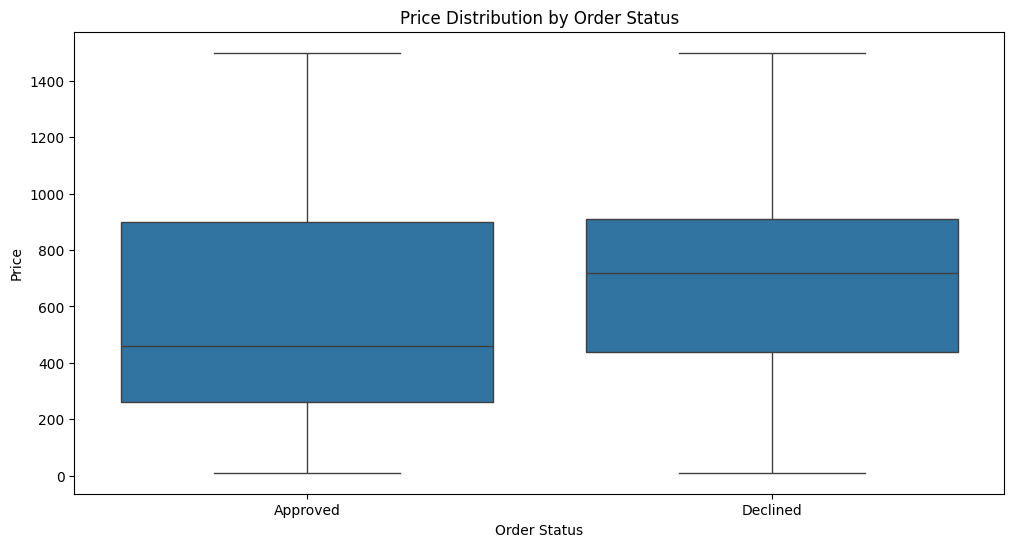

<ipython-input-16-01b4cd543d4d>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(x='status', y='price', data=df, jitter=True, palette='Set1')


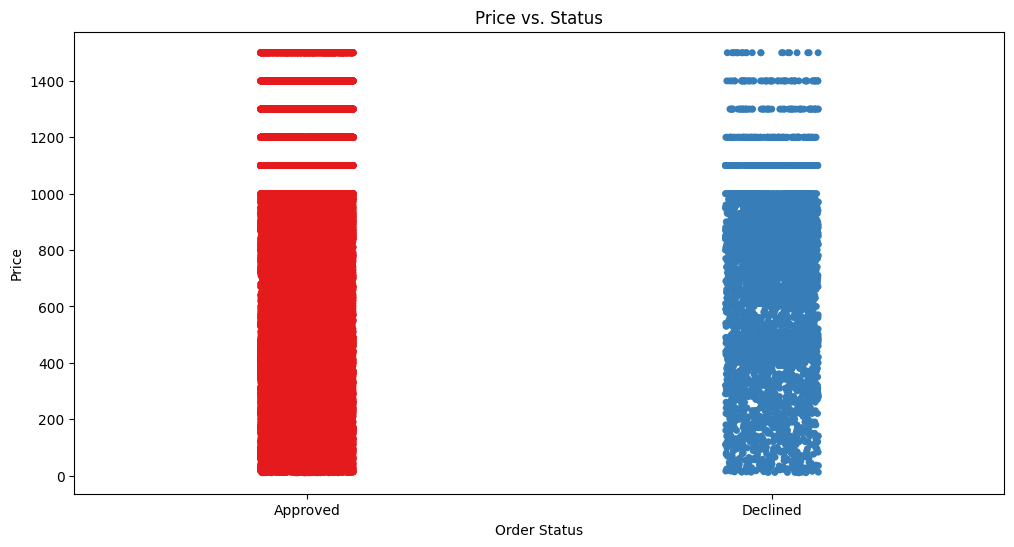

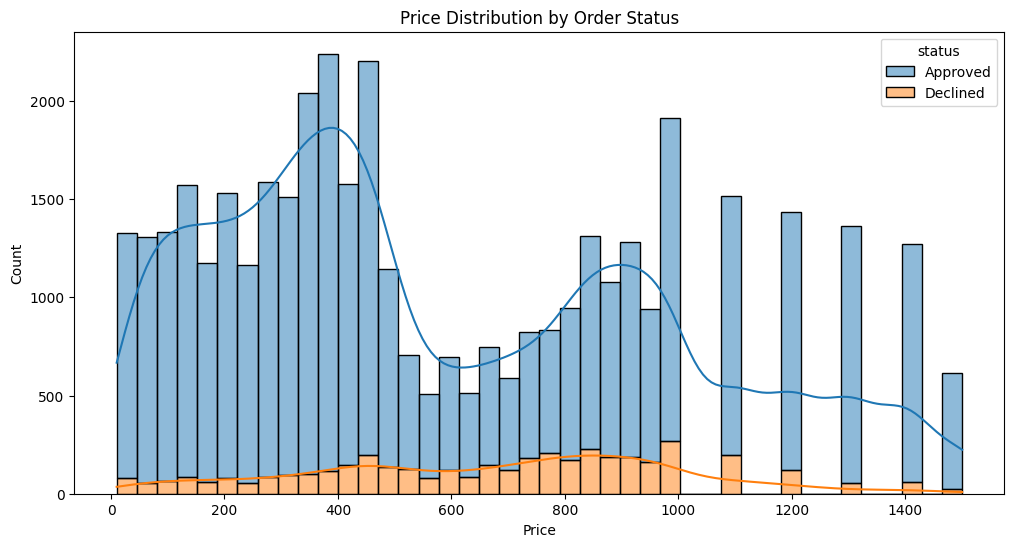

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Boxplot to show price distribution by status
plt.figure(figsize=(12, 6))
sns.boxplot(x='status', y='price', data=df)
plt.title('Price Distribution by Order Status')
plt.xlabel('Order Status')
plt.ylabel('Price')
plt.show()

# Scatter plot to show the relationship between price and status
plt.figure(figsize=(12, 6))
sns.stripplot(x='status', y='price', data=df, jitter=True, palette='Set1')
plt.title('Price vs. Status')
plt.xlabel('Order Status')
plt.ylabel('Price')
plt.show()

# Histogram to show the frequency distribution of prices by status
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='price', hue='status', multiple='stack', kde=True)
plt.title('Price Distribution by Order Status')
plt.xlabel('Price')
plt.ylabel('Count')
plt.show()


Summary statistics after normalization:


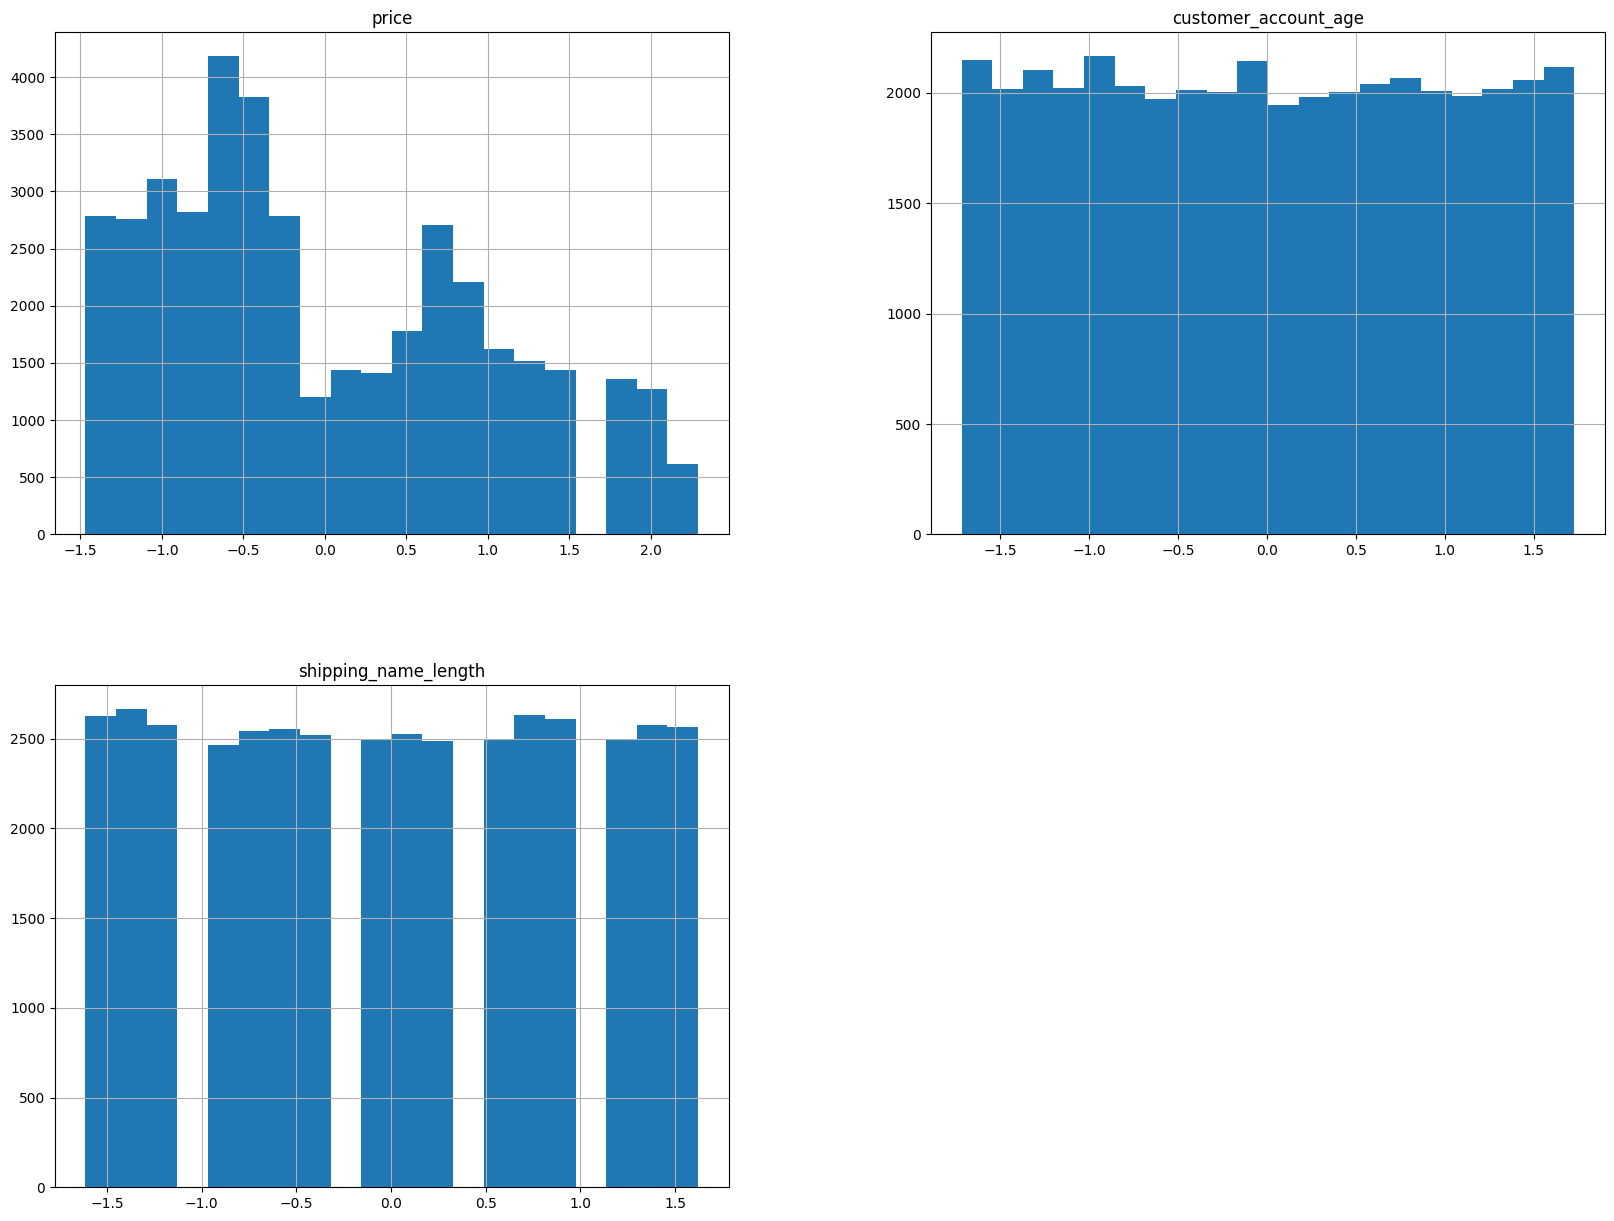

In [ ]:
from sklearn.preprocessing import StandardScaler
# Select columns that likely need normalization
columns_to_normalize = ['price', 'customer_account_age', 'shipping_name_length']

# Initialize StandardScaler
scaler = StandardScaler()

# Normalize the selected columns
df[columns_to_normalize] = scaler.fit_transform(df[columns_to_normalize])

# Check summary statistics after normalization
print("Summary statistics after normalization:")
df[columns_to_normalize].hist(bins=20, figsize=(20, 15))
plt.show()


In [ ]:
from sklearn.ensemble import RandomForestRegressor

# Calculate sample weights
class_weights = {0: 1.0, 1: 10.0}  # Adjust the weights according to your imbalance
sample_weights = y_train.map(class_weights)

# Create and train a Random Forest Regressor model
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train, sample_weight=sample_weights)

# Predict values
y_pred = model.predict(X_test)

# Ensure predictions are within the valid range if necessary (e.g., 0 and 1 for probabilities)
y_pred = np.clip(y_pred, 0, 1)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R²): {r2}")

,order_id,order_status,price,avs_mismatch,customer_account_age,order_source,billing_zip,shipping_name_length,classification_score,customer_id,status,order_year,order_month,order_day,order_dayofweek
0,621481,0,-0.131435,True,0.989331,1,41123,1.406480,0.371480,372,0,2023,6,11,6
1,788013,0,0.221860,True,-0.958884,1,71879,-1.398736,0.867578,860,0,2022,10,30,6
2,743724,1,-0.838024,False,0.979874,2,65701,1.622266,0.630769,971,0,2023,6,19,0
3,709340,0,0.322801,False,1.301424,0,63666,1.190694,0.431331,913,0,2021,2,28,6
4,816507,0,1.004155,True,-1.431752,1,86613,-0.967165,0.276696,905,0,2021,5,13,3


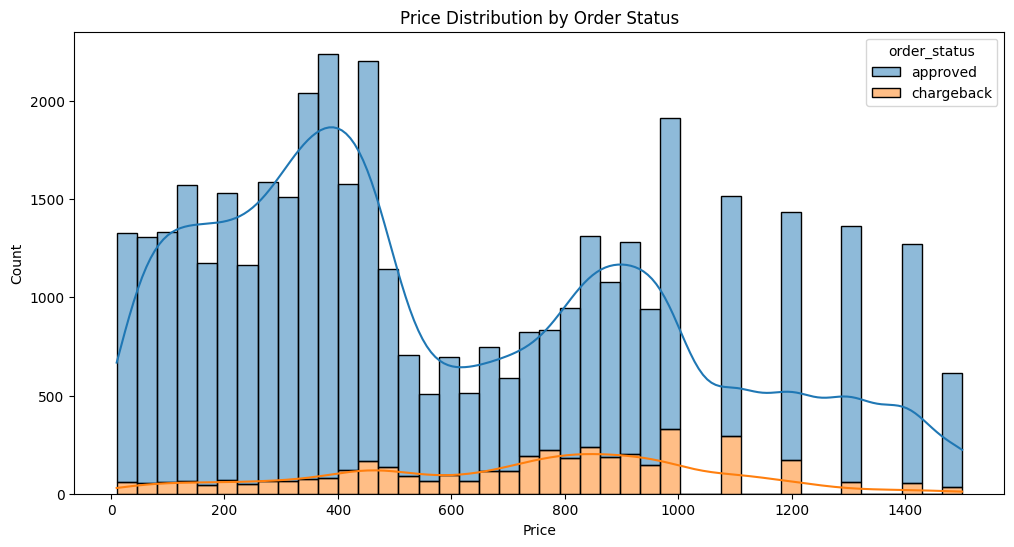

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns


# Histogram to show the frequency distribution of prices by status
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='price', hue='order_status', multiple='stack', kde=True)
plt.title('Price Distribution by Order Status')
plt.xlabel('Price')
plt.ylabel('Count')
plt.show()
